In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
import pytorch_models as pm
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["synth_noise","guitar","piano"])]



In [7]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


label
clap             118
hihat_closed     187
hihat_open       280
kick             648
rim              105
snare            731
synth_noise     6000
tom_high         179
tom_low          188
tom_mid          139
Name: path, dtype: int64


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [24]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
ds[0]

{'signal': tensor([-0.0003, -0.0019,  0.0305,  ...,  0.0000,  0.0000,  0.0000]),
 'label': tensor(0),
 'path': './dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav',
 'drum_type': 'tom_high'}

torch.Size([1, 30, 20]) tensor([2.7089e-01, 1.0000e+00, 9.9525e-02, 2.8777e-02, 8.0597e-03, 2.1778e-02,
        5.8507e-03, 5.1476e-03, 8.8775e-03, 1.3705e-02, 3.9223e-02, 2.5754e-02,
        4.0058e-02, 4.8776e-02, 4.9657e-02, 3.2399e-02, 2.2018e-02, 1.3158e-02,
        6.5534e-03, 2.6281e-03, 2.8343e-03, 2.9266e-03, 2.3655e-03, 1.4355e-03,
        4.1776e-04, 3.7945e-04, 1.5362e-03, 1.3450e-03, 1.8969e-03, 1.8023e-03])
('tom_high', 0) tensor(0) 44100


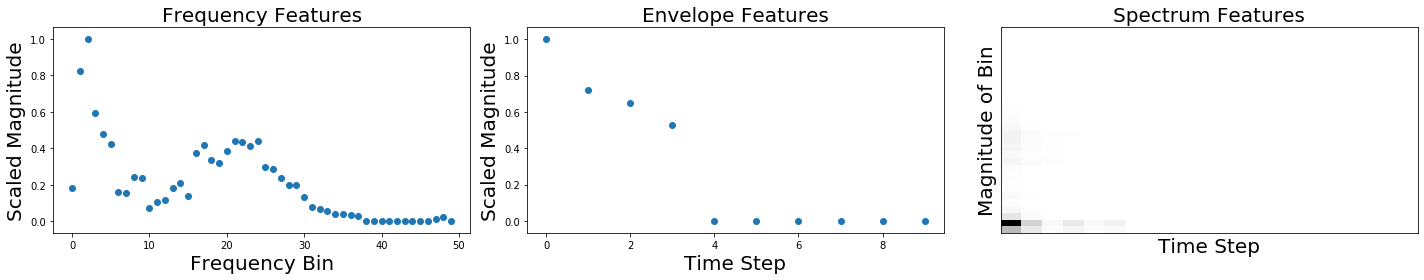

In [11]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
#         s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,ft[0,:,0])
        sf=ft.detach().numpy()[0]
        ft=ft.detach().numpy()[0]
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER

In [98]:

class AE(nn.Module):
    def __init__(self,compression_dim=64,**kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=256
        )
        self.encoder_output_layer = nn.Linear(
            in_features=256, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=kwargs["input_shape"]
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [20]:
compression_dim=64
spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=64,shuffle=True, num_workers=32)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)

In [21]:

train_synthless=train[train["label_num"]==0]
spec_data_train_nosynth = audioDataset(train,".",task="dvn", transform=pt)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)

epoch : 1/300, loss = 0.002284
saving
epoch : 2/300, loss = 0.002287
epoch : 3/300, loss = 0.002296
epoch : 4/300, loss = 0.002263
epoch : 5/300, loss = 0.002276
epoch : 6/300, loss = 0.002299
saving
epoch : 7/300, loss = 0.002261
epoch : 8/300, loss = 0.002263
epoch : 9/300, loss = 0.002263
epoch : 10/300, loss = 0.002245
epoch : 11/300, loss = 0.002248
saving
epoch : 12/300, loss = 0.002247
epoch : 13/300, loss = 0.002273
epoch : 14/300, loss = 0.002277
epoch : 15/300, loss = 0.002251
epoch : 16/300, loss = 0.002256
saving
epoch : 17/300, loss = 0.002241
epoch : 18/300, loss = 0.002239
epoch : 19/300, loss = 0.002235
epoch : 20/300, loss = 0.002227
epoch : 21/300, loss = 0.002251
saving
epoch : 22/300, loss = 0.002226
epoch : 23/300, loss = 0.002221
epoch : 24/300, loss = 0.002231
epoch : 25/300, loss = 0.002230
epoch : 26/300, loss = 0.002218
saving
epoch : 27/300, loss = 0.002224
epoch : 28/300, loss = 0.002226
epoch : 29/300, loss = 0.002228
epoch : 30/300, loss = 0.002213
epoch :

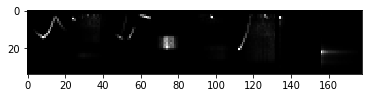

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed


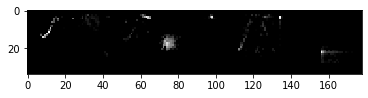

tensor([1, 1, 1, 1, 1, 1, 0, 0])


In [22]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
# model = AE(input_shape=spec_dimension).to(device)
# s=torch.load("models/encode/spec_encode_64_55_0.002290.pt")
# model = AE(input_shape=spec_dimension).to(device)
# model.load_state_dict(s)
# model.to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()
epochs=300
for epoch in range(epochs):
    
    loss = 0
#     for batch_features in spec_train_loader:
    for batch_features in spec_train_nosynth_loader:
        batch_features=batch_features["feats"]

        batch_features = batch_features.view(-1, spec_dimension).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(spec_train_nosynth_loader) 
    
#     display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    if epoch%5==0:
        print("saving")
        torch.save(model.state_dict(),'./models/encode/spec_encode_%d_%d_%f.pt'%(compression_dim,epoch,loss,))
        


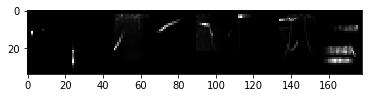

reconstructed


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


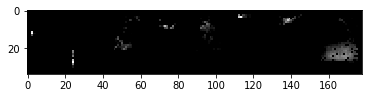

tensor([1, 0, 1, 1, 1, 0, 1, 1])


In [88]:
dataiter=iter(spec_test_loader)
#does it work?
xy=dataiter.next()
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images=xy["feats"].detach()[0:8]
y=xy["label"].detach()[0:8]
imshow(torchvision.utils.make_grid(images))

print("reconstructed")
image_batch=images.contiguous().view(-1, spec_dimension).to(device)
recon=model(image_batch).reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()
imshow(torchvision.utils.make_grid(recon))

print(y)

In [94]:
m


AE(
  (encoder_hidden_layer): Linear(in_features=600, out_features=256, bias=True)
  (encoder_output_layer): Linear(in_features=256, out_features=8, bias=True)
  (decoder_hidden_layer): Linear(in_features=8, out_features=256, bias=True)
  (decoder_output_layer): Linear(in_features=256, out_features=600, bias=True)
)

In [114]:
#extracting features and putting them into the csv folder for plotting
compression_dim=64

spec_dimension=FREQ_BINS*TIME_STEPS

# p="models/encode/spec_encode_sm_8_270_0.003504.pt"
model_path="spec_encode_64_290_0.002042.pt"
s=torch.load("models/encode/"+model_path)
m = AE(input_shape=spec_dimension,compression_dim=compression_dim).to(device)
m.load_state_dict(s)
m.to(device)
i=torch.randn([1,spec_dimension]).to(device)

encodings=np.empty([1,compression_dim+1])
i=0
d={"feats":[],"label":[],"path":[],"drum_type":[]}
for xy in spec_data_test:
#     print(xy)
    x=xy["feats"]
    y=xy["label"]
    p=xy["path"]
    drt=xy["drum_type"]

    m(x.contiguous().view(-1, spec_dimension).to(device))
    o=m.encoding.detach().cpu().numpy()
    d["feats"].append(list(o[0]))
    d["label"].append(y.item())
    d["path"].append(p)
    d["drum_type"].append(drt)

df=pd.DataFrame.from_dict(d)

df.to_csv("csvs/"+model_path+".csv",index=False)


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1715 samples in 0.002s...
[t-SNE] Computed neighbors for 1715 samples in 0.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1715
[t-SNE] Computed conditional probabilities for sample 1715 / 1715
[t-SNE] Mean sigma: 0.269872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.819092
[t-SNE] KL divergence after 1000 iterations: 1.297354
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1715 samples in 0.001s...
[t-SNE] Computed neighbors for 1715 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1715
[t-SNE] Computed conditional probabilities for sample 1715 / 1715
[t-SNE] Mean sigma: 0.078942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.715366
[t-SNE] KL divergence after 1000 iterations: 1.007133
